# 简答题

# 寻找地铁路线

## 爬虫爬取地铁路线数据（北京地铁）

In [1]:
import requests
def get_page(url):
    response = requests.get(url, verify=False)
    if response.encoding == 'ISO-8859-1':
        encodings = requests.utils.get_encodings_from_content(response.text)
        if encodings:
            encoding = encodings[0]
        else:
            encoding = response.apparent_encoding
        return response.content.decode(encoding, 'replace')
    else:
        return response.text

In [2]:
import re
def get_subway_lines():
    from bs4 import BeautifulSoup
    subway_lines_url = 'https://www.bjsubway.com/station/xltcx/'
    soup = BeautifulSoup(get_page(subway_lines_url), "lxml")
    
    subway_line_tags = soup.find_all("div", class_=re.compile("subway_num[1-9]([1-9]?)|station"))
    
    subway_lines = {}
    current_subway_line = None
    current_subway_line_stations = []
    for subway_line_tag in subway_line_tags:
        if subway_line_tag['class'][0].startswith('subway_num'):
            if current_subway_line:
                if current_subway_line == '8号线':
                    subway_lines['8号线北'] = current_subway_line_stations[0:19]
                    subway_lines['8号线南'] = current_subway_line_stations[19:]
                elif current_subway_line == '14号线':
                    subway_lines['14号线(西)'] = current_subway_line_stations[0:7]
                    subway_lines['14号线(东)'] = current_subway_line_stations[7:]
                else:
                    subway_lines[current_subway_line] = current_subway_line_stations
            current_subway_line = subway_line_tag.get_text()
            current_subway_line_stations = []
        else:
            current_subway_line_stations.append(subway_line_tag.get_text())
    subway_lines[current_subway_line] = current_subway_line_stations
    return subway_lines

In [3]:
subway_lines = get_subway_lines()

D:\Users\ZengYubin\Anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [4]:
subway_lines.keys()

dict_keys(['1号线', '2号线', '4号线', '5号线', '6号线', '7号线', '8号线北', '8号线南', '9号线', '10号线', '13号线', '14号线(西)', '14号线(东)', '15号线', '16号线', '八通线', '昌平线', '亦庄线', '房山线', '首都机场线', '大兴线', 'S1线'])

In [5]:
subway_lines['2号线']

['西直门',
 '积水潭',
 '鼓楼大街',
 '安定门',
 '雍和宫',
 '东直门',
 '东四十条',
 '朝阳门',
 '建国门',
 '北京站',
 '崇文门',
 '前门',
 '和平门',
 '宣武门',
 '长椿街',
 '复兴门',
 '阜成门',
 '车公庄']

In [6]:
import json 
def get_subway_station_coordinate(subway_station: str, city: str, ak: str):
    rquest_url = 'https://restapi.amap.com/v3/place/text?key={ak}&keywords={subway_station}地铁站&types=150500&city={city}&children=&offset=&page=&extensions=all'
    response = requests.get(rquest_url.format(subway_station=subway_station, city=city, ak=ak))
    content = json.loads(response.text)
    if content['status'] == '1':
        for poi in content['pois']:
            if poi['typecode'] == '150500':
                lng, lat = poi['location'].split(',')
                return (float(lng), float(lat))
    print('{} coordinate: (None, None)'.format(subway_station))
    return(None, None) 

In [7]:
get_subway_station_coordinate('动物园', '北京市', '7f0ce18c02a2074b1da8f0a8ed377b7d')

(116.339031, 39.93825)

In [8]:
def get_subway_station_location(subway_lines):
    subway_station_location =  {}
    for subway_line, subway_stations in subway_lines.items():
        subway_lines = []
        for subway_station in subway_stations:
            if subway_station in subway_station_location:
                subway_lines = subway_station_location[subway_station]['subway_lines']
                if subway_line not in subway_lines:
                    subway_lines.append(subway_line)
            else:
                coordinate = get_subway_station_coordinate(subway_station, '北京市', '7f0ce18c02a2074b1da8f0a8ed377b7d')
                subway_station_location[subway_station] = {'subway_lines': [subway_line], 'coordinate': coordinate}
    return subway_station_location

In [9]:
subway_station_location = get_subway_station_location(subway_lines)

In [10]:
subway_station_location['苹果园']

{'subway_lines': ['1号线', '6号线'], 'coordinate': (116.177388, 39.926727)}

In [11]:
subway_station_location

{'苹果园': {'subway_lines': ['1号线', '6号线'],
  'coordinate': (116.177388, 39.926727)},
 '古城': {'subway_lines': ['1号线'], 'coordinate': (116.190337, 39.90745)},
 '八角游乐园': {'subway_lines': ['1号线'], 'coordinate': (116.212684, 39.907442)},
 '八宝山': {'subway_lines': ['1号线'], 'coordinate': (116.235948, 39.90744)},
 '玉泉路': {'subway_lines': ['1号线'], 'coordinate': (116.252888, 39.907433)},
 '五棵松': {'subway_lines': ['1号线'], 'coordinate': (116.273987, 39.907456)},
 '万寿路': {'subway_lines': ['1号线'], 'coordinate': (116.294765, 39.907474)},
 '公主坟': {'subway_lines': ['1号线', '10号线'],
  'coordinate': (116.309919, 39.907469)},
 '军事博物馆': {'subway_lines': ['1号线', '9号线'],
  'coordinate': (116.321459, 39.907422)},
 '木樨地': {'subway_lines': ['1号线'], 'coordinate': (116.337583, 39.907379)},
 '南礼士路': {'subway_lines': ['1号线'], 'coordinate': (116.352583, 39.907234)},
 '复兴门': {'subway_lines': ['1号线', '2号线'],
  'coordinate': (116.356866, 39.907242)},
 '西单': {'subway_lines': ['1号线', '4号线'], 'coordinate': (116.374072, 39.907

In [12]:
from collections import defaultdict

def get_subway_station_connection(subway_lines):
    subway_station_connection = defaultdict(list)
    for subway_stations in subway_lines.values():
        for i in range(len(subway_stations) - 1):
            subway_station_connection[subway_stations[i]].append(subway_stations[i + 1])
            subway_station_connection[subway_stations[i + 1]].append(subway_stations[i])
    # 2号线、10号线闭环
    subway_station_connection['西直门'].append('车公庄')
    subway_station_connection['车公庄'].append('西直门')
    
    subway_station_connection['巴沟'].append('火器营')
    subway_station_connection['火器营'].append('巴沟')
    # 首都机场线
    subway_station_connection['3号航站楼'].remove('三元桥')
    subway_station_connection['3号航站楼'].append('2号航站楼')
    subway_station_connection['2号航站楼'].remove('3号航站楼')
    subway_station_connection['2号航站楼'].append('三元桥')
    
    return subway_station_connection

In [13]:
subway_station_connection = get_subway_station_connection(subway_lines)

In [14]:
subway_station_connection['车公庄']

['阜成门', '车公庄西', '平安里', '西直门']

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# %matplotlib inline

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

D:\Users\ZengYubin\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


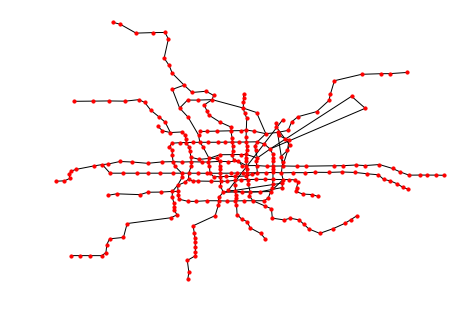

In [16]:
subway_station_connection_graph = nx.Graph(subway_station_connection)
nx.draw(subway_station_connection_graph, {subway_station : subway_station_location[subway_station]['coordinate'] for subway_station in subway_station_location.keys()}, node_size=10)

In [17]:
from collections import deque
def bfs_search(origin, destination, graph=subway_station_connection):
    """广度优先搜索"""
    
    route_queue = deque()
    visted_nodes = set()
    
    route_queue.append([origin])
    while route_queue:
        route = route_queue.popleft()
        if route[-1] in visted_nodes: continue
        
        for connect_node in graph[route[-1]]:
            if connect_node == destination:
                return route + [connect_node]
            # 检测闭环
            if connect_node in route: continue
            
            route_queue.append(route + [connect_node])
        visted_nodes.add(route[-1])

In [18]:
bfs_search('石厂', '3号航站楼')

['石厂',
 '小园',
 '栗园庄',
 '上岸',
 '桥户营',
 '四道桥',
 '金安桥',
 '苹果园',
 '杨庄',
 '西黄村',
 '廖公庄',
 '田村',
 '海淀五路居',
 '慈寿寺',
 '花园桥',
 '白石桥南',
 '车公庄西',
 '车公庄',
 '西直门',
 '积水潭',
 '鼓楼大街',
 '安定门',
 '雍和宫',
 '东直门',
 '三元桥',
 '3号航站楼']

# Optimal search

In [19]:
def optimal_search(origin, destination, *, search_strategy, graph=subway_station_connection):
    routes = list()
    
    routes.append([origin])
    while True:
        route = routes.pop(0)
        for connect_node in graph[route[-1]]:
            if connect_node in route: continue
            routes.append(route + [connect_node])
            
        if not routes: return
        
        routes = search_strategy(routes)
        if routes[0][-1] == destination:
            return routes[0]

In [20]:
def search_least_subway_station(subway_station_routes):
    """最少地铁站"""
    return sorted(subway_station_routes, key=lambda subway_station_route: len(subway_station_route))

In [21]:
optimal_search('石厂', '3号航站楼', search_strategy=search_least_subway_station)

['石厂',
 '小园',
 '栗园庄',
 '上岸',
 '桥户营',
 '四道桥',
 '金安桥',
 '苹果园',
 '杨庄',
 '西黄村',
 '廖公庄',
 '田村',
 '海淀五路居',
 '慈寿寺',
 '花园桥',
 '白石桥南',
 '车公庄西',
 '车公庄',
 '西直门',
 '积水潭',
 '鼓楼大街',
 '安定门',
 '雍和宫',
 '东直门',
 '三元桥',
 '3号航站楼']

In [22]:
def get_subway_station_route_transfer_times(subway_station_route):
    transfer_times = 1
    for i in range(len(subway_station_route) - 2):
        if not (set(subway_station_location[subway_station_route[i]]['subway_lines']) & set(subway_station_location[subway_station_route[i + 1]]['subway_lines']) & set(subway_station_location[subway_station_route[i + 2]]['subway_lines'])):
            transfer_times += 1
    return transfer_times

def search_minimum_transfer(subway_station_routes):
    """最少换乘"""
    return sorted(subway_station_routes, key=lambda subway_station_route: get_subway_station_route_transfer_times(subway_station_route))

In [23]:
optimal_search('石厂', '3号航站楼', search_strategy=search_minimum_transfer)

['石厂',
 '小园',
 '栗园庄',
 '上岸',
 '桥户营',
 '四道桥',
 '金安桥',
 '苹果园',
 '杨庄',
 '西黄村',
 '廖公庄',
 '田村',
 '海淀五路居',
 '慈寿寺',
 '花园桥',
 '白石桥南',
 '车公庄西',
 '车公庄',
 '平安里',
 '北海北',
 '南锣鼓巷',
 '东四',
 '朝阳门',
 '东大桥',
 '呼家楼',
 '团结湖',
 '农业展览馆',
 '亮马桥',
 '三元桥',
 '3号航站楼']

In [24]:
import math
def geo_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

def get_subway_stations_distance(origin, destination):
    return geo_distance(subway_station_location[origin]['coordinate'], subway_station_location[destination]['coordinate'])

In [25]:
get_subway_stations_distance('白石桥南', '车公庄西')

2.0463928361333146

In [27]:
def get_subway_station_route_distance(subway_station_route):
    return sum([get_subway_stations_distance(subway_station_route[i], subway_station_route[i + 1]) for i in range(len(subway_station_route) -1)])

def search_shortest_distance(subway_station_routes):
    """最短距离"""
    return sorted(subway_station_routes, key=lambda subway_station_route: get_subway_station_route_distance(subway_station_route))

In [29]:
optimal_search('石厂', '田村', search_strategy=search_shortest_distance)

['石厂', '小园', '栗园庄', '上岸', '桥户营', '四道桥', '金安桥', '苹果园', '杨庄', '西黄村', '廖公庄', '田村']

In [30]:
def search_optimal_path_minimum_transfer_and_shortest_distance(subway_station_routes):
    """搜索最优路径: 相同换乘情况下, 距离最短"""
    transfer_times_dict = defaultdict(list)
    for subway_station_route in subway_station_routes:
        transfer_times = get_subway_station_route_transfer_times(subway_station_route)
        transfer_times_dict[transfer_times].append(subway_station_route)
    transfer_times_list = sorted(transfer_times_dict.keys())
    sorted_subway_station_routes = []
    for transfer_times in transfer_times_list:
        sorted_subway_station_routes += search_shortest_distance(transfer_times_dict[transfer_times])
    return sorted_subway_station_routes

In [31]:
optimal_search('石厂', '3号航站楼', search_strategy=search_optimal_path_minimum_transfer_and_shortest_distance)

['石厂',
 '小园',
 '栗园庄',
 '上岸',
 '桥户营',
 '四道桥',
 '金安桥',
 '苹果园',
 '杨庄',
 '西黄村',
 '廖公庄',
 '田村',
 '海淀五路居',
 '慈寿寺',
 '花园桥',
 '白石桥南',
 '车公庄西',
 '车公庄',
 '西直门',
 '积水潭',
 '鼓楼大街',
 '安定门',
 '雍和宫',
 '东直门',
 '三元桥',
 '3号航站楼']

In [32]:
def search_optimal_path_minimum_transfer_and_least_subway_station(subway_station_routes):
    """搜索最优路径: 相同换乘情况下, 途径地铁站最少"""
    transfer_times_dict = defaultdict(list)
    for subway_station_route in subway_station_routes:
        transfer_times = get_subway_station_route_transfer_times(subway_station_route)
        transfer_times_dict[transfer_times].append(subway_station_route)
    transfer_times_list = sorted(transfer_times_dict.keys())
    sorted_subway_station_routes = []
    for transfer_times in transfer_times_list:
        sorted_subway_station_routes += search_least_subway_station(transfer_times_dict[transfer_times])
    return sorted_subway_station_routes

In [33]:
optimal_search('石厂', '3号航站楼', search_strategy=search_optimal_path_minimum_transfer_and_least_subway_station)

['石厂',
 '小园',
 '栗园庄',
 '上岸',
 '桥户营',
 '四道桥',
 '金安桥',
 '苹果园',
 '杨庄',
 '西黄村',
 '廖公庄',
 '田村',
 '海淀五路居',
 '慈寿寺',
 '花园桥',
 '白石桥南',
 '车公庄西',
 '车公庄',
 '西直门',
 '积水潭',
 '鼓楼大街',
 '安定门',
 '雍和宫',
 '东直门',
 '三元桥',
 '3号航站楼']

### Compare your results with results obtained by using some apps such as Baidu map, A map, Google map or Apple map. If there is difference, try to explanate it.
找到的路线与百度地图相同
